<a href="https://colab.research.google.com/github/mohammad-hosein/SSK-semiblind/blob/main/PNN_SSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import pandas as pd
import random
import tensorflow as tf
import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Input,Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
import os
os.getcwd()
import time

# Generating datasets and preprocessing

In [ ]:
'''Fading channel for specific number of antennas at transmitter and receiver side'''
j = complex(0, 1) #Imaginary part
def fading_channel (Nt, Nr):
  h_real = np.random.normal(0, 0.5, size = (Nr, Nt))
  h_img = np.random.normal(0, 0.5, size = (Nr, Nt))
  H_Rayleigh = np.array(h_real + h_img*j, dtype = complex)
  
  return H_Rayleigh

In [ ]:
'''SSK Constellation set'''
Constellation_set= np.zeros(shape= (4, 4))
Constellation_set[0] = np.array([1, 0, 0, 0])
Constellation_set[1] = np.array([0, 1, 0, 0])
Constellation_set[2] = np.array([0, 0, 1, 0])
Constellation_set[3] = np.array([0, 0, 0, 1])

In [ ]:
H_Rayleigh = fading_channel (4,2)

In [ ]:
'''Complex noise'''
def noise_complex (N0, Nr):
  n_real = np.random.normal(0, N0, size = Nr)
  n_img=np.random.normal(0, N0, size = Nr)
  noise_complex=np.array(n_real + n_img*j, dtype = complex)
  
  return noise_complex

In [ ]:
'''Creating pilot signals'''
def training_pilots_at_receiver (Label):
  i = 0
  
  y_receiver = np.zeros(shape = (4, 2), dtype = "complex_")
  for i in range(Label):
    y_receiver[i] = np.dot(H_Rayleigh, Constellation_set[i], out = None) + noise_complex (0.08, 2)
    i += 1

  y_receiver_real = y_receiver.real
  y_receiver_imag = y_receiver.imag
  y_receiver = np.concatenate((y_receiver_real, y_receiver_imag), axis = 1)
  y_receiver_complex = pd.DataFrame(y_receiver, columns=['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag'])
  y_receiver_complex['Label'] = np.arange(0, 4) 

  return y_receiver_complex

In [ ]:
training_pilots_at_receiver = training_pilots_at_receiver (4)

In [ ]:
'''Creating test signals'''
def test_ (packet_length):
  #Define an empty dataframe
  y_receive_test = pd.DataFrame()

  for i in range(packet_length):
    #Generating received signals
    y_one_receive_signal = np.zeros(shape = (1, 2), dtype = "complex_")
    
    #Choosing a random constellation point
    rand = random.randrange(0, 4, 1)
    
    #Y = HX+N 
    y_one_receive_signal = np.dot(H_Rayleigh, Constellation_set[rand], out = None) + noise_complex (0.08, 2)
    
    #Transforming complex signal to a two dimension integer
    y_one_receive_signal_real = y_one_receive_signal.real
    y_one_receive_signal_imag = y_one_receive_signal.imag
    y_receive = np.concatenate((y_one_receive_signal_real,y_one_receive_signal_imag), axis = None)
    
    #Filling dataframe rows
    y_receive_without_label = pd.DataFrame(y_receive.reshape((1, 4)), columns = ['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag'])
    
    #Assigning related label to received pilots
    if rand == 0 :
      y_receive_without_label['Label']= 0
    elif rand == 1 :
      y_receive_without_label['Label']= 1
    elif rand == 2 :
      y_receive_without_label['Label']= 2
    elif rand == 3 :
      y_receive_without_label['Label']= 3
    
    #Join all test signals to data set
    y_receive_test = pd.concat([y_receive_test, y_receive_without_label])

  return y_receive_test

In [ ]:
def test_label (KNN_or_NN): #Depend on model
  test = test_ (200)

  #Test data for KNN
  if KNN_or_NN == 1 :
    test_features = test[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']]
    test_label = test['Label']
    return test_features, test_label

  #Test data for NN
  elif KNN_or_NN == 0:
    test_features = test[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']]
    test_label_NN = test['Label']
    #test_label_categorical = to_categorical(test_label, num_classes = 4)
    return test_features, test_label_NN

In [ ]:
test_label (1)

(    Ant1_real  Ant2_real  Ant1_imag  Ant2_imag
 0   -0.507529  -0.467077  -0.544372  -0.246769
 0    0.374539  -0.478619  -0.471623  -0.531016
 0   -0.082008   0.556530  -0.202982   0.413463
 0   -0.516808  -0.556569  -0.569642   0.002578
 0    0.926076   0.574544  -0.692972   0.514474
 ..        ...        ...        ...        ...
 0    0.461453  -0.313042  -0.336462  -0.548577
 0   -0.563266  -0.418548  -0.519504  -0.145285
 0    0.255169  -0.307013  -0.332961  -0.339640
 0    0.894267   0.456515  -0.680567   0.753014
 0    0.866068   0.511367  -0.760873   0.617457
 
 [200 rows x 4 columns], 0    0
 0    1
 0    3
 0    0
 0    2
     ..
 0    1
 0    0
 0    1
 0    2
 0    2
 Name: Label, Length: 200, dtype: int64)

In [ ]:
x_test_svm, y_test_svm = test_label (1)
x_test_nn, y_test_nn = test_label (0)


# Generating virtual pilots (data augmentation)

In [ ]:
'''Noise for data augmentation'''
def noise_real (N0,Nr):
  noise_real=np.random.normal(0, N0, size=Nr)
  
  return noise_real

In [ ]:
def data_augmentation (sample_size, noise_variance):
  #Generating virtual pilots based on actual pilots
  augmented_data = pd.DataFrame()

  for i in range(sample_size):
    frame_augmented = training_pilots_at_receiver[['Ant1_real', 'Ant2_real', 'Ant1_imag', 'Ant2_imag']] + noise_real(noise_variance, 4)
    frame_augmented['Label'] = np.arange(0, 4)
    augmented_data = augmented_data.append(frame_augmented)
    i += 1

  return augmented_data

In [ ]:
data_augmentation = data_augmentation(70, 0.02)

In [ ]:
xa_plt = data_augmentation['Ant1_real']
ya_plt = data_augmentation['Ant1_imag']

xa2_plt = data_augmentation['Ant2_real']
ya2_plt = data_augmentation['Ant2_imag']

x_plt = training_pilots_at_receiver['Ant1_real']
y_plt = training_pilots_at_receiver['Ant1_imag']

x2_plt = training_pilots_at_receiver['Ant2_real']
y2_plt = training_pilots_at_receiver['Ant2_imag']

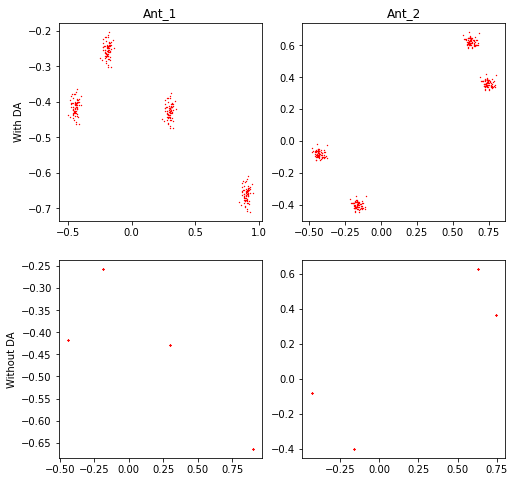

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.scatter(xa_plt, ya_plt,0.2,color ='red',marker='x')
plt.title('Ant_1')
plt.ylabel('With DA')

plt.subplot(2,2,2)
plt.scatter(xa2_plt, ya2_plt,0.2,color ='red',marker='x')
plt.title('Ant_2')
plt.subplot(2,2,3)
plt.scatter(x_plt, y_plt,2,color ='red',marker='x')
plt.ylabel('Without DA')

plt.subplot(2,2,4)
plt.scatter(x2_plt, y2_plt,2,color ='red',marker='x')
plt.savefig('4.eps')

In [ ]:
print(data_augmentation.describe())
print(training_pilots_at_receiver.describe())

        Ant1_real   Ant2_real   Ant1_imag   Ant2_imag       Label
count  280.000000  280.000000  280.000000  280.000000  280.000000
mean     0.140326    0.193353   -0.438815    0.126428    1.500000
std      0.512830    0.503660    0.146969    0.396068    1.120036
min     -0.497803   -0.485081   -0.709513   -0.441338    0.000000
25%     -0.282746   -0.256956   -0.508707   -0.175537    0.750000
50%      0.049349    0.232592   -0.419072    0.150780    1.500000
75%      0.469081    0.684757   -0.348192    0.462387    2.250000
max      0.947047    0.800734   -0.203014    0.684058    3.000000
       Ant1_real  Ant2_real  Ant1_imag  Ant2_imag     Label
count   4.000000   4.000000   4.000000   4.000000  4.000000
mean    0.141042   0.194324  -0.441754   0.129167  1.500000
std     0.590657   0.579908   0.167644   0.455862  1.290994
min    -0.441345  -0.430860  -0.663848  -0.397866  0.000000
25%    -0.252489  -0.230288  -0.487891  -0.157253  0.750000
50%     0.053406   0.231707  -0.423211   0.143

# Split dataset to train and test

In [ ]:
'''Spliting features and labels'''
#xy=pd.concat([data_augmentation, training_pilots_at_receiver])       #Enable when you want vp for SVM & KNN
xy = training_pilots_at_receiver                      #Enable when you dont want vp for SVM & KNN
xy_NN = pd.concat([data_augmentation, training_pilots_at_receiver])     #Enable when you want vp for NN
#xy_NN = training_pilots_at_receiver                   #Enable when you dont want vp for NN

In [ ]:
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.441345,-0.430860,-0.417183,-0.077049,0
1,0.296348,-0.163431,-0.429239,-0.397866,1
2,0.898702,0.626844,-0.663848,0.626779,2
3,-0.189537,0.744743,-0.256746,0.364802,3


#Preprocessing for KNN & SVM

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(xy.drop('Label',axis=1))

StandardScaler()

In [ ]:
scaled_features = scaler.transform(xy.drop('Label',axis=1))

In [ ]:
xy = pd.DataFrame(scaled_features,columns=xy.columns[:-1])
xy['Label']=np.arange(0,4)
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-1.138534,-1.244855,0.169239,-0.522344,0
1,0.303614,-0.712354,0.086201,-1.334977,1
2,1.481183,0.861226,-1.529737,1.260455,2
3,-0.646263,1.095983,1.274297,0.596866,3


#Preprocessing for PNN

In [ ]:
xy_NN

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-0.426347,-0.430431,-0.404016,-0.078542,0
1,0.311347,-0.163001,-0.416072,-0.399360,1
2,0.913701,0.627274,-0.650681,0.625285,2
3,-0.174538,0.745172,-0.243579,0.363308,3
0,-0.398012,-0.421274,-0.384904,-0.089355,0
...,...,...,...,...,...
3,-0.176794,0.727229,-0.259313,0.380813,3
0,-0.441345,-0.430860,-0.417183,-0.077049,0
1,0.296348,-0.163431,-0.429239,-0.397866,1
2,0.898702,0.626844,-0.663848,0.626779,2


In [ ]:
'''preprocessing for NN'''
x_NN=xy_NN[['Ant1_real','Ant2_real','Ant1_imag','Ant2_imag']]
y_NN=xy_NN['Label']
'''Labels one hot encoding'''
#y_NN=to_categorical(y_NN, num_classes=4)
'''Spliting data to train and validation'''
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x_NN, y_NN, test_size=0.3, random_state=101)

In [ ]:
'''Spliting features and labels for SVM & KNN'''
x=xy[['Ant1_real','Ant2_real','Ant1_imag','Ant2_imag']]
y=xy['Label']

In [ ]:
xy

,Ant1_real,Ant2_real,Ant1_imag,Ant2_imag,Label
0,-1.138534,-1.244855,0.169239,-0.522344,0
1,0.303614,-0.712354,0.086201,-1.334977,1
2,1.481183,0.861226,-1.529737,1.260455,2
3,-0.646263,1.095983,1.274297,0.596866,3


In [ ]:
'''Spliting data to train and validation'''
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.000001, random_state=101)
X_train=x
y_train=y

In [ ]:
X_train.shape

(4, 4)

In [ ]:
y_train.shape

(4,)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('loss')<0.07):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

# Building neural network and training

In [ ]:
model = Sequential()
model.add(Input(shape=(4)))
model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(4, activation='softmax'))

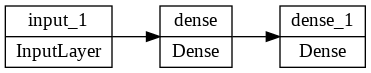

In [ ]:
plot_model(model, to_file='model.png', rankdir='LR')


In [ ]:
Start = int(round(time.time() * 1000))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_NN, y_train_NN, batch_size=32, epochs=50, validation_data=(X_test_NN,y_test_NN),callbacks=[callbacks])

Epoch 1/50
7/7 [==============================] - 1s 57ms/step - loss: 1.3267 - accuracy: 0.5202 - val_loss: 1.2977 - val_accuracy: 0.4535
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 1.2645 - accuracy: 0.5202 - val_loss: 1.2371 - val_accuracy: 0.4535
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 1.2051 - accuracy: 0.6869 - val_loss: 1.1766 - val_accuracy: 0.7558
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 1.1456 - accuracy: 0.9192 - val_loss: 1.1184 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 1.0871 - accuracy: 1.0000 - val_loss: 1.0602 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 1.0297 - accuracy: 1.0000 - val_loss: 1.0023 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.9722 - accuracy: 1.0000 - val_loss: 0.9448 - val_accuracy: 1.0000
Epoch 8/50
7/7 [===========

In [ ]:
End = int(round(time.time() * 1000))
print(End-Start)

5649


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#plot_decision_regions(X_test_NN, y_test_NN, clf=model, legend=2)
#plt.show()

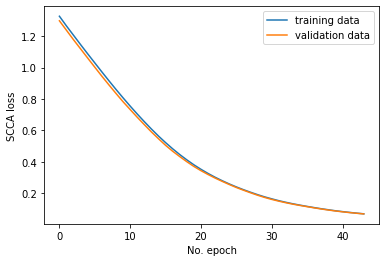

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
#plt.title('SCCA')
plt.ylabel('SCCA loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('14.pdf')

# Training KNN and SVM model

In [ ]:
rbf = svm.SVC(kernel = 'rbf', gamma = 0.5, C = 0.1).fit(X_train, y_train)
poly = svm.SVC(kernel = 'poly', degree = 3, C = 1).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

# Testing models on test dataset 

In [ ]:
poly_pred = poly.predict(x_test_svm)
rbf_pred = rbf.predict(x_test_svm)
knn_pred = knn.predict(x_test_svm)

In [ ]:
knn_accuracy = accuracy_score(y_test_svm, knn_pred)
knn_f1 = f1_score(y_test_svm, knn_pred, average ='weighted')
print('Accuracy (KNN): ', "%.2f" % (knn_accuracy*100))
print('F1 (KNN): ', "%.2f" % (knn_f1*100))

Accuracy (KNN):  100.00
F1 (KNN):  100.00


In [ ]:
poly_accuracy = accuracy_score(y_test_svm, poly_pred)
poly_f1 = f1_score(y_test_svm, poly_pred, average = 'weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  21.50
F1 (Polynomial Kernel):  7.61


In [ ]:
rbf_accuracy = accuracy_score(y_test_svm, rbf_pred)
rbf_f1 = f1_score(y_test_svm, rbf_pred, average = 'weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  100.00
F1 (RBF Kernel):  100.00


In [ ]:
'''Test the model'''
NN_Accuracy = model.evaluate(x_test_nn, y_test_nn)

7/7 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 1.0000


#Choosing K value

In [ ]:
'''error_rate = []

for i in range(1,4):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(m1)
    error_rate.append(np.mean(pred_i != n1))'''

'error_rate = []\n\nfor i in range(1,4):\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train,y_train)\n    pred_i = knn.predict(m1)\n    error_rate.append(np.mean(pred_i != n1))'

In [ ]:
'''plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',ls='--',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs. K Values')
plt.xlabel('K')
plt.ylabel('Error Rate')'''

"plt.figure(figsize=(10,6))\nplt.plot(range(1,40),error_rate,color='blue',ls='--',marker='o',markerfacecolor='red',markersize=10)\nplt.title('Error Rate vs. K Values')\nplt.xlabel('K')\nplt.ylabel('Error Rate')"